In [1]:
# dataset obtained from: https://www.kaggle.com/blastchar/telco-customer-churn

In [2]:
##### PART 1: DATA PREPROCESSING AND EXPLORATION

In [3]:
%reset -f

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(123)

In [4]:
# import dataset
full = pd.read_csv('../data/customer_churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# keep only those observations where tenure > 0 (since customers wouldn't leave before the service has started)
full = full[full['tenure']>0]
full = full.reset_index(drop=True) # to avoid concatenation problems later

# view shape of dataset
full.shape

(7032, 21)

In [5]:
# view first few obs of dataset
print(full.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...  DeviceProtection  \
0  No phone service             DSL             No  ...                No   
1                No             DSL            Yes  ...               Yes   
2                No             DSL            Yes  ...                No   
3  No phone service             DSL            Yes  ...               Yes   
4                No     Fiber optic             No  ...                No   

  TechSupport StreamingTV StreamingMovies        Contrac

In [6]:
# extract target variable
target = full['Churn']
del full['Churn']

# delete unwanted variables
del full['customerID']

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64


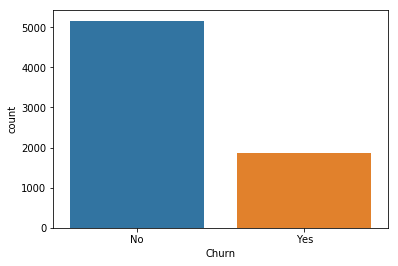

In [7]:
# view distribution of target variable
sns.countplot(target) # target variable has imbalanced classes; most customers in the dataset don't churn

print(pd.Series(target).value_counts()/full.shape[0]) # 73% of customers don't churn; the baseline model's accuracy is 73%

       SeniorCitizen       tenure  MonthlyCharges
count    7032.000000  7032.000000     7032.000000
mean        0.162400    32.421786       64.798208
std         0.368844    24.545260       30.085974
min         0.000000     1.000000       18.250000
25%         0.000000     9.000000       35.587500
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.862500
max         1.000000    72.000000      118.750000


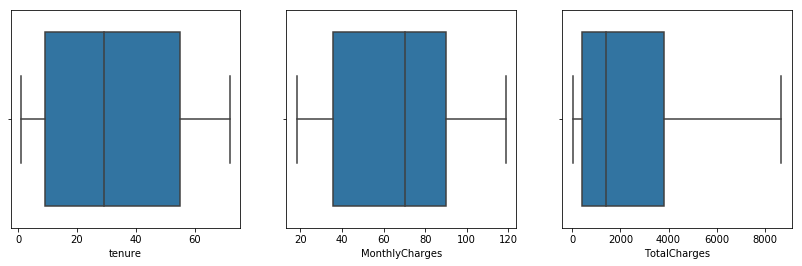

In [8]:
# check for outliers and data entry errors
print(full.describe()) # seems like there are no data entry errors. but TotalCharges should be converted to a numeric variable

full['TotalCharges'] = pd.to_numeric(full['TotalCharges'], errors='coerce')

fig, saxis = plt.subplots(1, 3, figsize=(14,4)) # to fit 1 rows and 3 columns worth of subplots in one plot
sns.boxplot(x = 'tenure', data=full, ax = saxis[0]) # no outliers
sns.boxplot(x = 'MonthlyCharges', data=full, ax = saxis[1]) # no outliers
sns.boxplot(x = 'TotalCharges', data=full, ax=saxis[2]) # no outliers

In [9]:
# check for missing values
print(full.isnull().any().describe()) # no missing values

count        19
unique        1
top       False
freq         19
dtype: object


In [10]:
# feature engineering
#full['totalcharges_div_monthlycharges'] = full['TotalCharges'] / full['MonthlyCharges']

#full['totalcharges_div_tenure'] = full['TotalCharges'] / full['tenure']

In [11]:
# one-hot encode string variables
full = pd.get_dummies(full,
                      drop_first=True)

In [12]:
# feature engineering: PCA

from sklearn.preprocessing import StandardScaler
full_scaled = StandardScaler().fit_transform(full)

from sklearn.decomposition import PCA
pca = PCA(n_components=None)
full_scaled_pc = pca.fit_transform(full_scaled)

print('percentage of variance explained by PC:\n', pca.explained_variance_ratio_)

three_principal_components = pd.DataFrame(pd.DataFrame(full_scaled_pc).iloc[:,0:3].values, columns=['pc1','pc2','pc3'])

full = pd.concat([full, three_principal_components], axis='columns')

percentage of variance explained by PC:
 [3.31601383e-01 1.20090615e-01 9.01453604e-02 4.75499305e-02
 4.14301148e-02 4.12062738e-02 3.81528947e-02 3.33678430e-02
 3.12304397e-02 2.95429845e-02 2.65961293e-02 2.37964294e-02
 2.24944460e-02 2.05590830e-02 2.02482905e-02 1.74856860e-02
 1.55526514e-02 1.52541395e-02 1.46713170e-02 9.23412008e-03
 7.84361734e-03 1.91635429e-03 2.98961869e-05 1.36953849e-32
 2.47073638e-33 2.47073638e-33 2.47073638e-33 2.47073638e-33
 2.47073638e-33 2.47073638e-33]


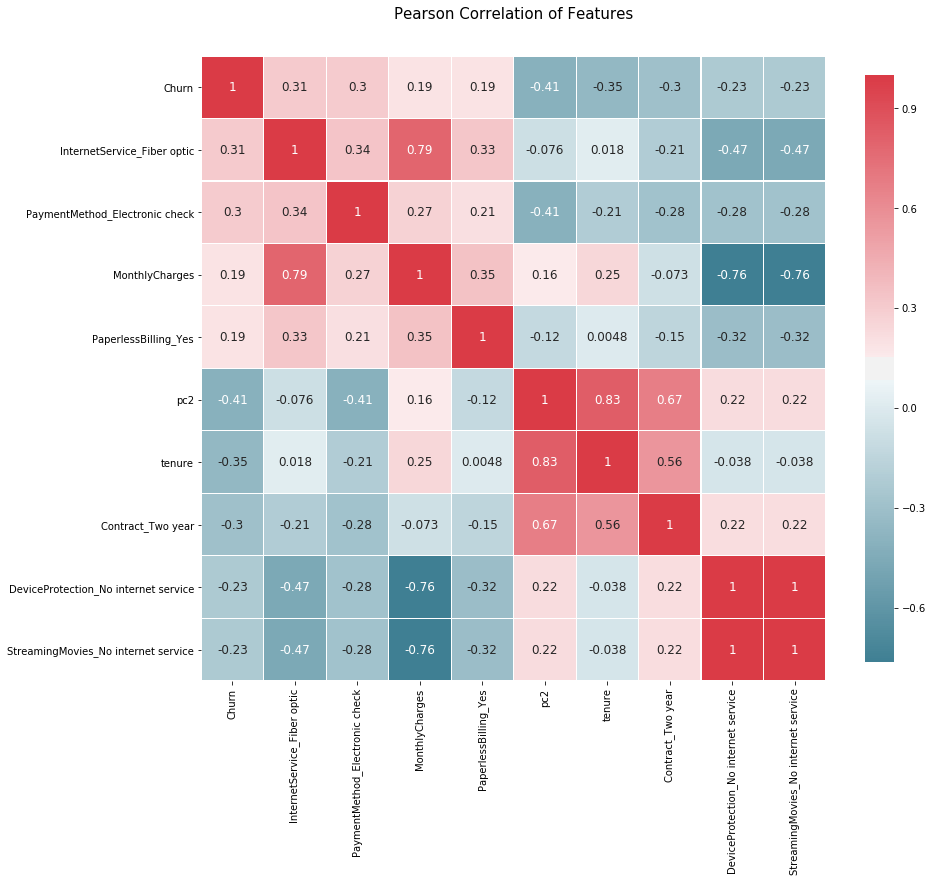

In [13]:
full_target = pd.concat([full,target], axis=1)
dict1 = {'Yes':1, 'No':0}
full_target['Churn'] = full_target['Churn'].map(dict1)

full_target_corr = pd.concat([full_target[full_target.corr()['Churn'].sort_values(ascending=False)[0:5].index], # top variables most positively correlated with Churn
                              full_target[full_target.corr()['Churn'].sort_values(ascending=True)[0:5].index]], # top variables most negatively correlated with Churn
                             axis=1)

# useful visualization: correlation heatmap
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(full_target_corr)

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


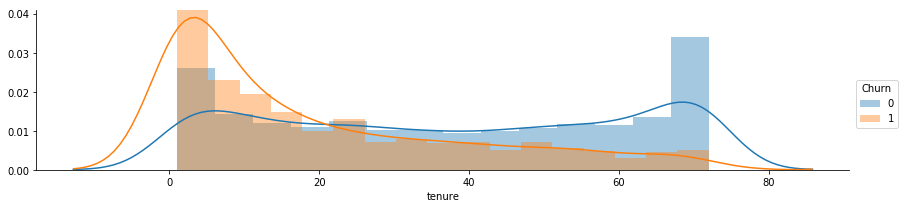

In [14]:
# useful visualization: kernel density plots
a = sns.FacetGrid(full_target, hue = 'Churn', aspect=4 ) # use the dataset 'full', and plot one 'tenure' distribution per category of 'Churn'
a.map(sns.distplot, 'tenure', kde=True) # kernel density plot of 'tenure'
#a.set(xlim=(0, full_target['tenure'].max())) # set the boundaries of x-axis
a.add_legend() # add a legend for the distributions

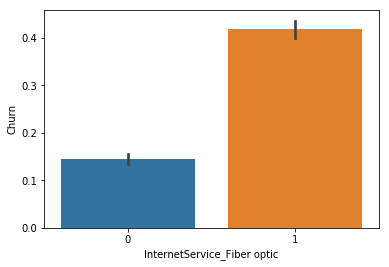

In [15]:
# useful visualization: barplot
sns.barplot(x='InternetService_Fiber optic', y='Churn', data=full_target)

In [16]:
# split dataset into train and test sets
from sklearn import model_selection

xtrain, xtest, ytrain, ytest = model_selection.train_test_split(full, target, test_size=0.2)

In [17]:
##### PART 2: BUILD A NEURAL NETWORK WITH TENSORFLOW

In [18]:
# scale the features, and convert dataframe to array
from sklearn.preprocessing import StandardScaler

xtrain_tf = StandardScaler().fit_transform(xtrain)
xtest_tf = StandardScaler().fit_transform(xtest)

# transform target variable to numeric, convert target dataframes to arrays, and reshape training target to suitable shape for tensorflow
ytrain_tf = np.array(ytrain.map({'Yes':1, 'No':0}))
ytest_tf = np.array(ytest.map({'Yes':1, 'No':0}))

ytrain_tf = ytrain_tf.reshape(ytrain.shape[0],1)

In [19]:
import tensorflow as tf

# create a function that trains a neural network, then generates predictions on the test set
def main(xtrain, ytrain, xtest):
    max_iter = 30 # number of iterations to train the model for
    lr = 0.0004 # learning rate
    
    Xtrain = xtrain
    Ytrain = ytrain
    
    N, D = Xtrain.shape # there are D neurons in the input layer, where D = number of features in the training set
    batch_sz = 100 # batch size
    n_batches = int(N / batch_sz) # number of batches
    
    M1 = 20 # number of neurons in first hidden layer
    M2 = 10 # number of neurons in second hidden layer
    K = 1 # number of neurons in output layer. K=1 because the classification problem is binary
    W1_init = np.random.randn(D,M1) / 28 # DxM1 matrix of weights, connecting the input and first hidden layer
    b1_init = np.zeros(M1) # M1-dimensional vector of biases, connecting the input and first hidden layer
    W2_init = np.random.randn(M1, M2) / np.sqrt(M1) # M1xM2 matrix of weights, connecting the first and second hidden layers
    b2_init = np.zeros(M2) # M2-dimensional vector of biases, connecting the first and second hidden layers
    W3_init = np.random.randn(M2, K) / np.sqrt(M2) # M2xK matrix of weights, connecting the second hidden and output layer
    b3_init = np.zeros(K) # K-dimensional vector of biases, connecting the second hidden and output layer
    
    X = tf.placeholder(tf.float32, shape=(None,D), name='X') # to store input data
    T = tf.placeholder(tf.float32, shape=(None,K), name='T') # to store true values of dependent variable
    W1 = tf.Variable(W1_init.astype(np.float32)) # store the weights/biases
    b1 = tf.Variable(b1_init.astype(np.float32)) # store the weights/biases
    W2 = tf.Variable(W2_init.astype(np.float32)) # store the weights/biases
    b2 = tf.Variable(b2_init.astype(np.float32)) # store the weights/biases
    W3 = tf.Variable(W3_init.astype(np.float32)) # store the weights/biases
    b3 = tf.Variable(b3_init.astype(np.float32)) # store the weights/biases
    
    Z1 = tf.nn.relu(tf.matmul(X, W1) + b1) # first hidden layer
    Z2 = tf.nn.relu(tf.matmul(Z1, W2) + b2) # second hidden layer
    Yish = tf.matmul(Z2, W3) + b3 # output layer, but lacking activation function
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Yish, labels=T)) # cost function for binary classification
    
    train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost) # algorithm to optimize the weights and biases
    
    predict_op = tf.round(tf.nn.sigmoid(Yish)) # generate predictions
    
    init = tf.global_variables_initializer() # initialize variables
    
    with tf.Session() as session:
        session.run(init) # run the initialization operation
        
        for i in range(max_iter):
            for j in range(n_batches):
                Xbatch = Xtrain[j*batch_sz: j*batch_sz+batch_sz,] # get the batch of training features
                Ybatch = Ytrain[j*batch_sz: j*batch_sz+batch_sz,] # get the batch of training labels
                
                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch}) # run the weights optimization operation
        predictions = session.run(predict_op, feed_dict={X: xtest}) # generate predictions on the test set
    
    return predictions # return the predictions

# call the function
preds = main(xtrain_tf, ytrain_tf, xtest_tf)

In [20]:
# check the accuracy of the model's predictions on the test set
test_eval = pd.Series(preds.reshape(preds.shape[0])==ytest_tf)
print("The accuracy of the test predictions is %.3f" % test_eval.mean())

The accuracy of the test predictions is 0.800


In [21]:
##### PART 3: BUILD MODELS WITH SKLEARN

In [22]:
# random forest
from sklearn.ensemble import RandomForestClassifier

# initialize model
rfc = RandomForestClassifier()

# cross validation
rfc_cv = model_selection.cross_validate(rfc,
                                        xtrain,
                                        ytrain,
                                        scoring='accuracy',
                                        cv=10)

print('The mean training accuracy is:',rfc_cv['train_score'].mean())
print('The mean cross-validation accuracy is:',rfc_cv['test_score'].mean())

The mean training accuracy is: 0.9810371223798089
The mean cross-validation accuracy is: 0.7816919168914984


In [23]:
# xgboost
from xgboost import XGBClassifier

# initialize model
xgb = XGBClassifier()

# cross validation
xgb_cv = model_selection.cross_validate(xgb,
                                        xtrain,
                                        ytrain,
                                        scoring='accuracy',
                                        cv=10)

print('The mean training accuracy is:',xgb_cv['train_score'].mean())
print('The mean cross-validation accuracy is:',xgb_cv['test_score'].mean())

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

The mean training accuracy is: 0.8236246849374634
The mean cross-validation accuracy is: 0.7985930332317569


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [24]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier

# initialize model
ada = AdaBoostClassifier()

# cross validation
ada_cv = model_selection.cross_validate(ada,
                                        xtrain,
                                        ytrain,
                                        scoring='accuracy',
                                        cv=10)

print('The mean training accuracy is:',ada_cv['train_score'].mean())
print('The mean cross-validation accuracy is:',ada_cv['test_score'].mean())

The mean training accuracy is: 0.8122470005018767
The mean cross-validation accuracy is: 0.8001884438891287


In [25]:
# lightgbm
from lightgbm import LGBMClassifier

# initialize model
lgb = LGBMClassifier()

# cross validation
lgb_cv = model_selection.cross_validate(lgb,
                                        xtrain,
                                        ytrain,
                                        scoring='accuracy',
                                        cv=10)

print('The mean training accuracy is:',lgb_cv['train_score'].mean())
print('The mean cross-validation accuracy is:',lgb_cv['test_score'].mean())

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

The mean training accuracy is: 0.9047704635403037
The mean cross-validation accuracy is: 0.7905909523068936


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

In [26]:
# k nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

# initialize model
knn = KNeighborsClassifier()

# cross validation
knn_cv = model_selection.cross_validate(knn,
                                        xtrain,
                                        ytrain,
                                        scoring='accuracy',
                                        cv=10)

print('The mean training accuracy is:',knn_cv['train_score'].mean())
print('The mean cross-validation accuracy is:',knn_cv['test_score'].mean())

The mean training accuracy is: 0.8304594597724584
The mean cross-validation accuracy is: 0.7694367842313836


In [27]:
# support vector machine
from sklearn.svm import SVC

# initialize model
svc = SVC(kernel='rbf', # radial basis function, which is a Gaussian kernel
          C=0.5, # penalty of the error term; higher C leads to more overfitting (because margin size is sacrificed for training accuracy)
          gamma=0.001) # kernel coefficient for rbf. defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’

# cross validation
svc_cv = model_selection.cross_validate(svc,
                                        xtrain,
                                        ytrain,
                                        scoring='accuracy',
                                        cv=10)

print('The mean training accuracy is:',svc_cv['train_score'].mean())
print('The mean cross-validation accuracy is:',svc_cv['test_score'].mean())

The mean training accuracy is: 0.8047605279006997
The mean cross-validation accuracy is: 0.7872038337485189


In [28]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# initialize model
logreg = LogisticRegression()

# cross validation
logreg_cv = model_selection.cross_validate(logreg,
                                           xtrain,
                                           ytrain,
                                           scoring='accuracy',
                                           cv=10)

print('The mean training accuracy is:',logreg_cv['train_score'].mean())
print('The mean cross-validation accuracy is:',logreg_cv['test_score'].mean())

The mean training accuracy is: 0.8045039698851596
The mean cross-validation accuracy is: 0.8024984529060639


In [29]:
# stacked model
from sklearn.ensemble import VotingClassifier

# initialize model
votingC = VotingClassifier(estimators=[('rfc', rfc),
                                       ('xgb', xgb),
                                       ('ada', ada),
                                       ('lgb', lgb),
                                       ('knn', knn),
                                       ('svc', svc),
                                       ('logreg', logreg)],
                           voting='hard')

# cross validation
voting_cv = model_selection.cross_validate(votingC,
                                           xtrain,
                                           ytrain,
                                           scoring='accuracy',
                                           cv=10)

print('The mean training accuracy is:',voting_cv['train_score'].mean())
print('The mean cross-validation accuracy is:',voting_cv['test_score'].mean())

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

The mean training accuracy is: 0.852898650526251
The mean cross-validation accuracy is: 0.8005459016570949


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
# fit each model
rfc_fit = rfc.fit(xtrain,ytrain)
xgb_fit = xgb.fit(xtrain,ytrain)
ada_fit = ada.fit(xtrain,ytrain)
lgb_fit = lgb.fit(xtrain,ytrain)
knn_fit = knn.fit(xtrain,ytrain)
svc_fit = svc.fit(xtrain,ytrain)
logreg_fit = logreg.fit(xtrain,ytrain)
votingC_fit = votingC.fit(xtrain,ytrain)

# use each model to generate predictions
ytest = pd.DataFrame({'churn':ytest})
ytest.reset_index(drop=True, inplace=True)

preds_rfc = rfc_fit.predict(xtest)
preds_rfc = pd.DataFrame({'pred_rfc':preds_rfc})
preds_rfc.reset_index(drop=True, inplace=True)

preds_xgb = xgb_fit.predict(xtest)
preds_xgb = pd.DataFrame({'pred_xgb':preds_xgb})
preds_xgb.reset_index(drop=True, inplace=True)

preds_ada = ada_fit.predict(xtest)
preds_ada = pd.DataFrame({'pred_ada':preds_ada})
preds_ada.reset_index(drop=True, inplace=True)

preds_lgb = lgb_fit.predict(xtest)
preds_lgb = pd.DataFrame({'pred_lgb':preds_lgb})
preds_lgb.reset_index(drop=True, inplace=True)

preds_knn = knn_fit.predict(xtest)
preds_knn = pd.DataFrame({'pred_knn':preds_knn})
preds_knn.reset_index(drop=True, inplace=True)

preds_svc = svc_fit.predict(xtest)
preds_svc = pd.DataFrame({'pred_svc':preds_svc})
preds_svc.reset_index(drop=True, inplace=True)

preds_logreg = logreg_fit.predict(xtest)
preds_logreg = pd.DataFrame({'pred_logreg':preds_logreg})
preds_logreg.reset_index(drop=True, inplace=True)

preds_votingC = votingC_fit.predict(xtest)
preds_votingC = pd.DataFrame({'pred_votingC':preds_votingC})
preds_votingC.reset_index(drop=True, inplace=True)

ytest_preds = pd.concat([ytest,preds_rfc,preds_xgb,preds_ada,preds_lgb,preds_knn,preds_svc,preds_logreg,preds_votingC], axis='columns')

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

In [31]:
# check the test accuracy of the predictions
ytest_preds['rfc_correct'] = 0
ytest_preds.loc[ytest_preds['churn']==ytest_preds['pred_rfc'],'rfc_correct'] = 1
print('the test accuracy of random forest is:', ytest_preds['rfc_correct'].mean())

ytest_preds['xgb_correct'] = 0
ytest_preds.loc[ytest_preds['churn']==ytest_preds['pred_xgb'],'xgb_correct'] = 1
print('the test accuracy of xgboost is:', ytest_preds['xgb_correct'].mean())

ytest_preds['ada_correct'] = 0
ytest_preds.loc[ytest_preds['churn']==ytest_preds['pred_ada'],'ada_correct'] = 1
print('the test accuracy of adaboost is:', ytest_preds['ada_correct'].mean())

ytest_preds['lgb_correct'] = 0
ytest_preds.loc[ytest_preds['churn']==ytest_preds['pred_lgb'],'lgb_correct'] = 1
print('the test accuracy of lightgbm is:', ytest_preds['lgb_correct'].mean())

ytest_preds['knn_correct'] = 0
ytest_preds.loc[ytest_preds['churn']==ytest_preds['pred_knn'],'knn_correct'] = 1
print('the test accuracy of k nearest neighbors is:', ytest_preds['knn_correct'].mean())

ytest_preds['svc_correct'] = 0
ytest_preds.loc[ytest_preds['churn']==ytest_preds['pred_svc'],'svc_correct'] = 1
print('the test accuracy of support vector machine is:', ytest_preds['svc_correct'].mean())

ytest_preds['logreg_correct'] = 0
ytest_preds.loc[ytest_preds['churn']==ytest_preds['pred_logreg'],'logreg_correct'] = 1
print('the test accuracy of logistic regression is:', ytest_preds['logreg_correct'].mean())

ytest_preds['votingC_correct'] = 0
ytest_preds.loc[ytest_preds['churn']==ytest_preds['pred_votingC'],'votingC_correct'] = 1
print('the test accuracy of voting classifier is:', ytest_preds['votingC_correct'].mean())

the test accuracy of random forest is: 0.7633262260127932
the test accuracy of xgboost is: 0.8009950248756219
the test accuracy of adaboost is: 0.7938877043354655
the test accuracy of lightgbm is: 0.7867803837953091
the test accuracy of k nearest neighbors is: 0.7661691542288557
the test accuracy of support vector machine is: 0.7782515991471215
the test accuracy of logistic regression is: 0.8116560056858564
the test accuracy of voting classifier is: 0.7995735607675906


In [32]:
# view confusion matrix; bottom-right shows sensitivity/recall/TPR, top-left shows specificity/TNR
from sklearn.metrics import confusion_matrix

for x in ['pred_rfc','pred_xgb','pred_ada','pred_lgb','pred_knn','pred_svc','pred_logreg','pred_votingC']:
    cm = confusion_matrix(ytest_preds['churn'], ytest_preds[x])
    cm[0] = cm[0]/cm[0].sum()*100
    cm[1] = cm[1]/cm[1].sum()*100
    print(cm, x)
    print('-'*25)

[[91  8]
 [59 40]] pred_rfc
-------------------------
[[91  8]
 [47 52]] pred_xgb
-------------------------
[[90  9]
 [47 52]] pred_ada
-------------------------
[[91  8]
 [51 48]] pred_lgb
-------------------------
[[89 10]
 [54 45]] pred_knn
-------------------------
[[93  6]
 [60 39]] pred_svc
-------------------------
[[92  7]
 [45 54]] pred_logreg
-------------------------
[[92  7]
 [50 49]] pred_votingC
-------------------------


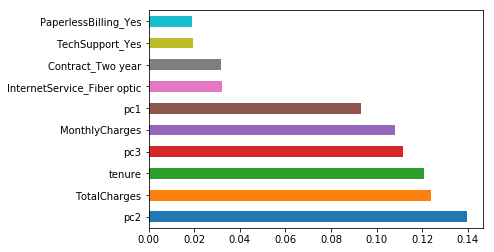

In [33]:
# plot feature importance (as determined by the built random forest model)
feature_importances = pd.Series(rfc_fit.feature_importances_, index=xtrain.columns)
feature_importances = feature_importances.sort_values(ascending=False) # sort from highest to lowest importance; for pandas dataframe sorting, refer to https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
feature_importances.nlargest(10).plot(kind='barh')

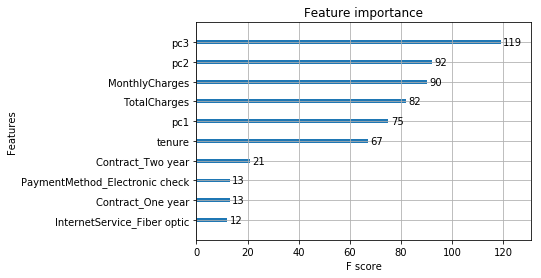

In [34]:
# plot feature importance (as determined by the built xgboost model)
from xgboost import plot_importance
plot_importance(xgb_fit,
                max_num_features = 10)